## Pneumonia Detection

#### *Table of Contents*
1. [Data preprocessing](#chapter1)
2. [Data augmentation with Albumentations](#chapter2)
3. [CNN model architecture](#chapter3)
4. [Training & ](#chapter4)
5. [Fine Tuning & Increamental unfreezing of base model](#chapter5)
6. [Evaluation of the model](#chapter6)

- libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import tensorflow as tf
import random
from collections import Counter
from albumentations import Compose, HorizontalFlip, Rotate, RandomBrightnessContrast, GaussianBlur, ShiftScaleRotate
from albumentations.core.transforms_interface import ImageOnlyTransform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMG_SIZE = 128
given_labels = ['PNEUMONIA', 'NORMAL']

train_dir = '../data/chest_xray/train'
test_dir = '../data/chest_xray/test'
val_dir = '../data/chest_xray/val'

### 1. Data preprocessing

In [3]:
def get_images_array(dir):
    data = []
    for given_label in given_labels:
        path = os.path.join(dir, given_label)
        label = given_labels.index(given_label)  
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                if image_array is None:
                    raise ValueError(f"Image {image} could not be loaded. Check file format and path.")
                
                resized_img = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
                
                data.append([resized_img, label]) 
            except Exception as e:
                print(f"Error processing image {os.path.join(path, image)}: {e}")   # .DS_STORE found and deleted
    
    return np.array(data, dtype=object)     # image + label

In [4]:
train_data = get_images_array(train_dir)
test_data = get_images_array(test_dir)
val_data = get_images_array(val_dir)

Error processing image ../data/chest_xray/train\NORMAL\.DS_Store: Image .DS_Store could not be loaded. Check file format and path.


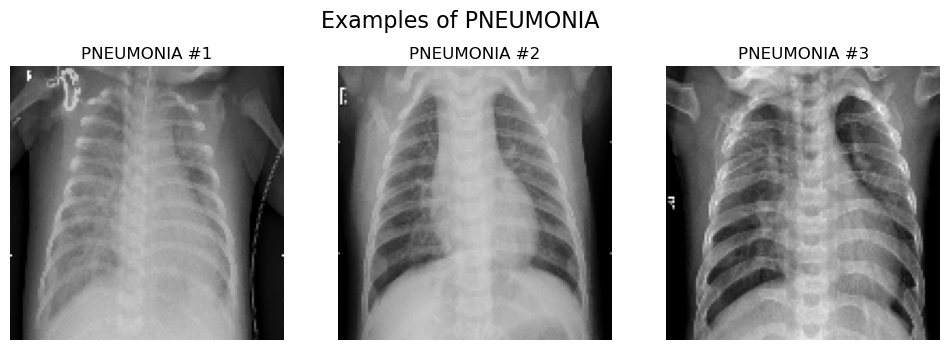

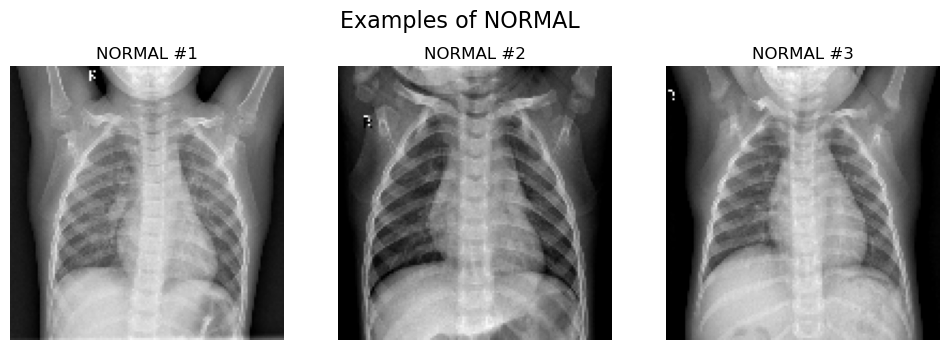

In [14]:
def display_images(data, label_name, label_value, count=3):
    """
    Display a set number of images for a given label.
    
    :param data: Array of images and labels.
    :param label_name: The label name (e.g., 'PNEUMONIA', 'NORMAL').
    :param label_value: The numerical value of the label.
    :param count: Number of images to display.
    """
    # get proper label
    filtered_images = [item[0] for item in data if item[1] == label_value][:count]
    
    fig, axes = plt.subplots(1, count, figsize=(12, 4))
    fig.suptitle(f"Examples of {label_name}", fontsize=16)
    for i, image in enumerate(filtered_images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{label_name} #{i + 1}")
    
    plt.show()

display_images(train_data, 'PNEUMONIA', given_labels.index('PNEUMONIA'), count=3)
display_images(train_data, 'NORMAL', given_labels.index('NORMAL'), count=3)

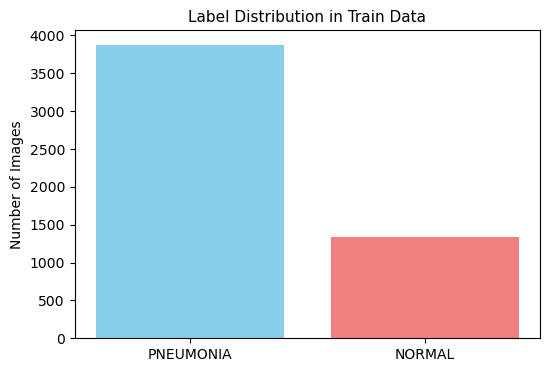

Counter({0: 3875, 1: 1341})


In [17]:
def plot_label_distribution(data, labels):
    label_counts = Counter([item[1] for item in data])
    
    # data prep
    label_names = [labels[idx] for idx in label_counts.keys()]
    counts = [label_counts[idx] for idx in label_counts.keys()]
    
    plt.figure(figsize=(6, 4))
    plt.bar(label_names, counts, color=['skyblue', 'lightcoral'])
    plt.title('Label Distribution in Train Data', fontsize=11)
    plt.ylabel('Number of Images', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()
    print(label_counts)
    return label_counts

label_counts = plot_label_distribution(train_data, given_labels)

### 2. Data augmentation

In [21]:
def augment_data_albumentations(data, target_class, augment_count, img_size):
    """
    Augments data for the given target class using to balance the dataset.
    
    :param data: Original data (list of [image, label]).
    :param target_class: The class label to augment.
    :param augment_count: The desired number of augmented images to add.
    :param img_size: The target size of images.
    :return: Augmented dataset with balanced classes.
    """
    # get target class images
    class_images = [item[0] for item in data if item[1] == target_class]
    
    # Albumentations augmentations
    augmentations = Compose([
        HorizontalFlip(p=0.5),
        Rotate(limit=15, p=0.7),
        RandomBrightnessContrast(p=0.3),
    ])
    
    augmented_images = []
    augmented_labels = []
    for _ in range(augment_count):
        image = random.choice(class_images)
        image = cv2.resize(image, (img_size, img_size))  # TARGET SIZE (IMG_SIZE = 128)
        
        augmented_image = augmentations(image=image)["image"]
        augmented_images.append(augmented_image)
        augmented_labels.append(target_class)
    
    for img, label in zip(augmented_images, augmented_labels):
        data.append([img, label])
    
    return data

In [22]:
# PARAMS
target_class = 1    #  0:PNEUMONIA | 1:NORMAL

augment_count = label_counts[0] - label_counts[1]  

# Augment the data
balanced_train_data = augment_data_albumentations(train_data.tolist(), target_class, augment_count, IMG_SIZE)

# new distribution check
new_distribution = Counter([item[1] for item in balanced_train_data])
print("New class distribution:", new_distribution)

New class distribution: Counter({0: 3875, 1: 3875})


In [ ]:
# split data and labels
train_images = np.array([item[0] for item in balanced_train_data]).astype('float32') / 255.0
train_labels = to_categorical([item[1] for item in balanced_train_data], num_classes=2)

val_images = np.array([item[0] for item in val_data]).astype('float32') / 255.0
val_labels = to_categorical([item[1] for item in val_data], num_classes=2)

In [43]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Train images shape: (7750, 128, 128)
Train labels shape: (7750, 2)
Validation images shape: (16, 128, 128)
Validation labels shape: (16, 2)


- combining validation and test data (only 16 val examples)

In [44]:
test_images = np.array([item[0] for item in test_data]).astype('float32') / 255.0
test_labels = to_categorical([item[1] for item in test_data], num_classes=2)

In [45]:
val_images = np.concatenate([val_images, test_images], axis=0)
val_labels = np.concatenate([val_labels, test_labels], axis=0)

print("New Validation images shape:", val_images.shape)
print("New Validation labels shape:", val_labels.shape)

New Validation images shape: (640, 128, 128)
New Validation labels shape: (640, 2)


In [ ]:
# dim expansion
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

train_images = np.repeat(train_images, 3, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)

Train images shape after expansion: (7750, 128, 128, 3)
Validation images shape after expansion: [[[[0.06666667 0.06666667 0.06666667]
   [0.07450981 0.07450981 0.07450981]
   [0.07843138 0.07843138 0.07843138]
   ...
   [0.06666667 0.06666667 0.06666667]
   [0.05098039 0.05098039 0.05098039]
   [0.05882353 0.05882353 0.05882353]]

  [[0.06666667 0.06666667 0.06666667]
   [0.08235294 0.08235294 0.08235294]
   [0.10196079 0.10196079 0.10196079]
   ...
   [0.1764706  0.1764706  0.1764706 ]
   [0.10196079 0.10196079 0.10196079]
   [0.06666667 0.06666667 0.06666667]]

  [[0.06666667 0.06666667 0.06666667]
   [0.07843138 0.07843138 0.07843138]
   [0.10588235 0.10588235 0.10588235]
   ...
   [0.18039216 0.18039216 0.18039216]
   [0.16470589 0.16470589 0.16470589]
   [0.11764706 0.11764706 0.11764706]]

  ...

  [[0.02352941 0.02352941 0.02352941]
   [0.01960784 0.01960784 0.01960784]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00784314 0.00784314 

In [51]:
print("Train images shape after expansion:", train_images.shape)
print("Validation images shape after expansion:",val_images.shape)

Train images shape after expansion: (7750, 128, 128, 3)
Validation images shape after expansion: (640, 128, 128, 3)


### 3. Model 

In [ ]:
base_model = VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(4608, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

model_01 = Model(base_model.inputs, output)


In [56]:
model_01.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 79,025,218 (301.46 MB)

 Trainable params: 59,000,834 (225.07 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

- callbacks:

In [57]:
early_stop = EarlyStopping(monitor ='val_loss', verbose=1, mode='min', patience=5)

filepath = "model_pneumonia.keras"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, 
                             mode='auto')

rl_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, nesterov=True)

model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### 4. Training

In [58]:
assert train_images.shape[1:] == (128, 128, 3), f"Unexpected train image shape: {train_images.shape[1:]}"
assert val_images.shape[1:] == (128, 128, 3), f"Unexpected validation image shape: {val_images.shape[1:]}"
assert train_labels.shape[1] == 2, f"Unexpected train label shape: {train_labels.shape[1]}"
assert val_labels.shape[1] == 2, f"Unexpected validation label shape: {val_labels.shape[1]}"

train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
train_labels = train_labels.astype('float32')
val_labels = val_labels.astype('float32')

In [59]:
model_01.fit(
    x=train_images,
    y=train_labels,
    validation_data=(val_images, val_labels),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop, checkpoint, rl_reduce]
)

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.6882 - loss: 0.6256 - val_accuracy: 0.7922 - val_loss: 0.5612 - learning_rate: 1.0000e-04
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.8557 - loss: 0.4926 - val_accuracy: 0.8000 - val_loss: 0.4974 - learning_rate: 1.0000e-04
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.8816 - loss: 0.4207 - val_accuracy: 0.8078 - val_loss: 0.4633 - learning_rate: 1.0000e-04
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.8880 - loss: 0.3727 - val_accuracy: 0.8109 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.8990 - loss: 0.3420 - val_accuracy: 0.8141 - val_loss: 0.4254 - learning_rate: 1.0000e-04
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9076 - loss: 0.3124 - val_accuracy: 0.8094 - val_loss: 0.4234 - learning_rate: 1.0000e-04
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - acc

In [60]:
model_01.save("../models/pneumonia/pneumonia_detection_model.h5")
model_01.save('../models/pneumonia/pneumonia_detection_model.keras')
print("Model saved.")

Model saved.


### 5. Incremental training 

In [76]:
model_01 = Model(base_model.input, output)

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:  
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


sgd = SGD(learning_rate=0.0001, nesterov=True)

model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Training last layers
model_01.fit(
    x=train_images,
    y=train_labels,
    validation_data=(val_images, val_labels),
    batch_size=32,
    epochs=10,  
    callbacks=[early_stop, checkpoint, rl_reduce]
)


Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9489 - loss: 0.1438 - val_accuracy: 0.8297 - val_loss: 0.3855 - learning_rate: 1.0000e-04
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.9486 - loss: 0.1503 - val_accuracy: 0.8203 - val_loss: 0.4297 - learning_rate: 1.0000e-04
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step - accuracy: 0.9526 - loss: 0.1389 - val_accuracy: 0.8266 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 2450s 10s/step - accuracy: 0.9522 - loss: 0.1317 - val_accuracy: 0.8156 - val_loss: 0.4404 - learning_rate: 1.0000e-04
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9593 - loss: 0.1288 - val_accuracy: 0.8125 - val_loss: 0.4581 - learning_rate: 1.0000e-04
Epoch 5: early stopping


### 6. Evaluation

In [69]:
print(f"train_images shape: {train_images.shape}")
print(f"val_images shape: {val_images.shape}")
print(f"test_images shape: {test_images.shape}")

print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

print(np.unique(train_labels))  # Sprawdź unikalne etykiety


train_images shape: (7750, 128, 128, 3)
val_images shape: (640, 128, 128, 3)
test_images shape: (624, 128, 128)
train_labels shape: (7750, 2)
val_labels shape: (640, 2)
test_labels shape: (624, 2)
[0. 1.]


In [ ]:
# missing channel
test_images = np.expand_dims(test_images, axis=-1)  

test_images = np.repeat(test_images, 3, axis=-1)  

print(f"test_images shape after adjustment: {test_images.shape}")

test_images shape after adjustment: (624, 128, 128, 3)


In [71]:
test_loss, test_accuracy = model_01.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9272 - loss: 0.2092
Test Loss: 0.3920, Test Accuracy: 0.8221


- prediction

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step


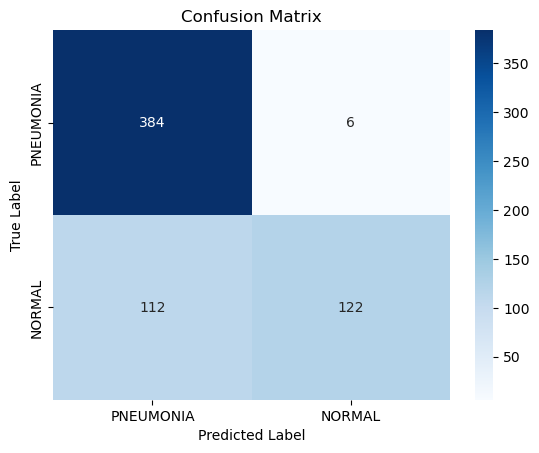

In [78]:
predictions = model_01.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=given_labels, yticklabels=given_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [79]:
report = classification_report(true_labels, predicted_labels, target_names=['No pneumonia', 'pneumonia'])
print(report)

              precision    recall  f1-score   support

No pneumonia       0.77      0.98      0.87       390
   pneumonia       0.95      0.52      0.67       234

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624

